# PDHG(TV正則化)

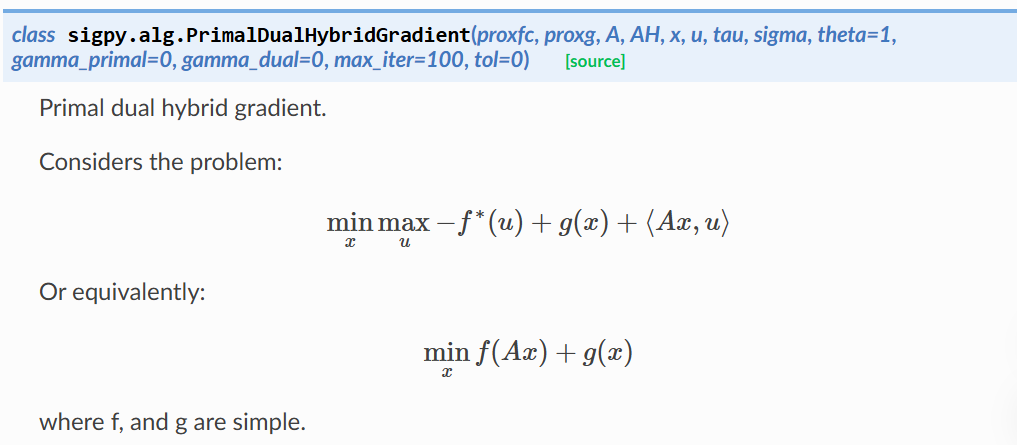

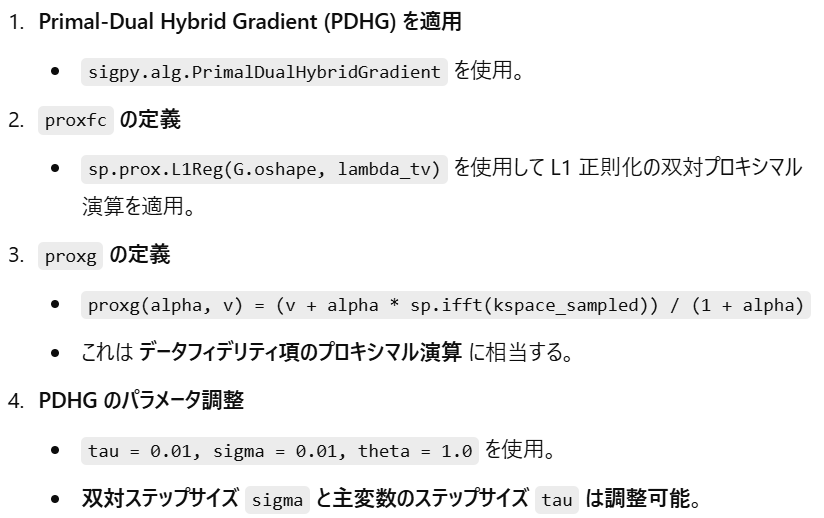

# proxgにCG適用

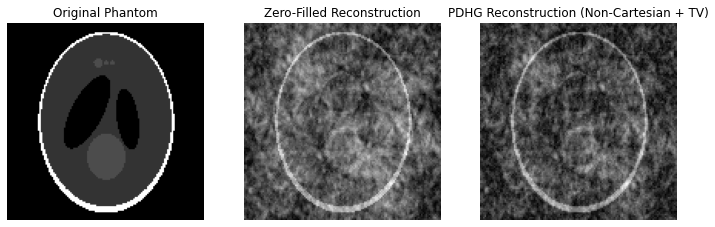

In [1]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# **1. Shepp-Logan Phantom の作成**
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# **2. Spiral k-space (Non-Cartesian サンプリング) の作成**
coords = mri.spiral(
    fov=0.3,         # 視野 (FOV) 30cm
    N=N,             # 画像サイズ
    f_sampling=1.0,  # サンプリングファクター
    R=3,             # Undersampling rate
    ninterleaves=1,  # Interleaves の数
    alpha=1.0,       # 可変密度 Spiral の設定
    gm=0.04,         # 最大勾配強度
    sm=150,          # 最大スルーレート
)

# **3. Non-Cartesian Fourier Transform の設定**
nufft_op = sp.linop.NUFFT(phantom.shape, coord=coords)  # NUFFT オペレータ
nufft_adj = nufft_op.H  # Adjoint Operator (A^H)

# **4. Spiral サンプリング適用 (Non-Cartesian k-space)**
kspace_sampled = nufft_op(phantom)  # Spiral k-space データ

# **5. Zero-Filled Reconstruction**
img_zero_filled = nufft_adj(kspace_sampled).astype(np.complex128)

# **6. TV 正則化の係数**
lambda_tv = 0.01  # TV正則化の強さ

# **7. PDHG のパラメータ**
tau = 0.01   # Primal step-size
sigma = 0.01  # Dual step-size
theta = 1.0   # Accelerated parameter

# **8. 線形オペレータ (NUFFT + TV)**
A = nufft_op  # Spiral のサンプリング行列
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # TV 正則化の微分演算子

# **9. `proxg` (データフィデリティ項のプロキシマル演算, CG 法で解く)**
AHA = A.H * A + sp.linop.Identity(A.ishape)  # A^H A + I

def proxg(alpha, v):
    """データフィデリティ項のプロキシマル演算 (共役勾配法で解く)"""
    b = v + alpha * nufft_adj(kspace_sampled)  # 右辺
    cg_solver = sp.alg.ConjugateGradient(AHA, b, v, max_iter=10)  # 共役勾配法

    while not cg_solver.done():
        cg_solver.update()
    
    return v  # 更新された x を返す

# **10. `proxfc` (L1 正則化の双対プロキシマル演算)**
proxfc = sp.prox.L1Reg(G.oshape, lambda_tv)  # L1正則化

# **11. 初期化**
x = np.copy(img_zero_filled)  # 初期画像
u = np.zeros(G.oshape, dtype=np.complex64)  # 初期双対変数

# **12. PDHG による最適化**
pdhg_solver = sp.alg.PrimalDualHybridGradient(
    proxfc=proxfc,
    proxg=proxg,
    A=G,
    AH=G.H,
    x=x,
    u=u,
    tau=tau,
    sigma=sigma,
    theta=theta,
    max_iter=100
)

# **13. 画像再構成**
while not pdhg_solver.done():
    pdhg_solver.update()

# **14. 結果を取得**
reconstructed_img = np.abs(x)

# **15. 結果を可視化**
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("PDHG Reconstruction (Non-Cartesian + TV)")
axs[2].axis("off")

plt.show()
